<a href="https://colab.research.google.com/github/FunmilolaAdetuwo/Final-Project/blob/main/Advanced_AI_Techniques_for_Predicting_Currency_Exchange_Rates_A_Deep_Learning_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Instal the World bank library

!pip install wbdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
bigframes 1.24.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


In [27]:
# Importing necessary libraries

import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import wbdata as wb
import seaborn as sns

First, we will be fetching the currency data from the Yahoo Finance.
The GBP and the USD will be the currency that will be used for this project
The period that will be used for this project will be from 01 January 2013 to 31 December 2023

In [20]:
# Defining the ticker symbol for GBP/USD
tcker_symb = "GBPUSD=X"

# Setting the data range
strt_dt = "2013-01-01"
ed_dt = "2023-12-31"

# Fetching the data
crcy_dt = yf.download(tcker_symb, start=strt_dt, end=ed_dt)

# setting the index to convert the index to a date column
crcy_dt.reset_index(inplace=True)

# Flattening the columns
crcy_dt.columns = ['_'.join(col).strip() if col[1] else col[0] for col in crcy_dt.columns.values]

crcy_dt['Date'] = pd.to_datetime(crcy_dt['Date'])


# Display the data structure after modification
print("Data after flattening columns and setting 'Date':")
print(crcy_dt.head())

[*********************100%***********************]  1 of 1 completed

Data after flattening columns and setting 'Date':
                       Date  Adj Close_GBPUSD=X  Close_GBPUSD=X  \
0 2013-01-01 00:00:00+00:00            1.623640        1.623640   
1 2013-01-02 00:00:00+00:00            1.624695        1.624695   
2 2013-01-03 00:00:00+00:00            1.625250        1.625250   
3 2013-01-04 00:00:00+00:00            1.608234        1.608234   
4 2013-01-07 00:00:00+00:00            1.606787        1.606787   

   High_GBPUSD=X  Low_GBPUSD=X  Open_GBPUSD=X  Volume_GBPUSD=X  
0       1.632200      1.623377       1.623640                0  
1       1.638404      1.624431       1.624695                0  
2       1.625488      1.615091       1.625224                0  
3       1.609010      1.601537       1.607795                0  
4       1.608260      1.602282       1.606684                0  


Now, using the same period, we will fetch the macro economic data from the World bank for the United Kingdom and United States.

The indicators we will be using is the GDP and Inflation rate.

In [9]:
# Setting the date range
dt_dte = ("2013", "2023")

# Getting the GDP and Inflation data for US and UK
gdp_dt = wb.get_data("NY.GDP.MKTP.CD", country=['GBR', 'USA'], date=dt_dte)
ifltn_dt = wb.get_data("FP.CPI.TOTL.ZG", country=['GBR', 'USA'], date=dt_dte)

# Converting this into DataFrames
gdp_df = pd.DataFrame(gdp_dt)
ifltn_df = pd.DataFrame(ifltn_dt)

def extract_dict_value(row, key):
    return row[key]['value'] if isinstance(row[key], dict) else row[key]

gdp_df['country'] = gdp_df['country'].apply(extract_dict_value, key='value')
gdp_df['indicator'] = gdp_df['indicator'].apply(extract_dict_value, key='value')

ifltn_df['country'] = ifltn_df['country'].apply(extract_dict_value, key='value')
ifltn_df['indicator'] = ifltn_df['indicator'].apply(extract_dict_value, key='value')

gdp_df['date'] = pd.to_datetime(gdp_df['date'])
ifltn_df['date'] = pd.to_datetime(ifltn_df['date'])

gdp_pt = gdp_df.pivot(index='date', columns='country', values='value').rename(columns=lambda x: f"GDP_{x}")
ifltn_pt = ifltn_df.pivot(index='date', columns='country', values='value').rename(columns=lambda x: f"Inflation_{x}")

# Merging the GDP and Inflation data into a single DataFrame
ecomc_dt = gdp_pt.join(ifltn_pt, how='outer')

# Displaying the data
print(ecomc_dt.head())


country     GDP_United Kingdom  GDP_United States  Inflation_United Kingdom  \
date                                                                          
2013-01-01        2.784854e+12       1.688068e+13                  2.291667   
2014-01-01        3.064708e+12       1.760814e+13                  1.451120   
2015-01-01        2.927911e+12       1.829502e+13                  0.368047   
2016-01-01        2.689107e+12       1.880491e+13                  1.008417   
2017-01-01        2.680148e+12       1.961210e+13                  2.557756   

country     Inflation_United States  
date                                 
2013-01-01                 1.464833  
2014-01-01                 1.622223  
2015-01-01                 0.118627  
2016-01-01                 1.261583  
2017-01-01                 2.130110  


The Currency data and the Macroeconomic data will now be merged together

In [23]:
crcy_dt['Date'] = crcy_dt['Date'].dt.tz_localize(None)
ecomc_dt.index = ecomc_dt.index.tz_localize(None)

# Merging the daily currency data with the economic data using forward fill to handle the missing daily values
cmbd_dt = pd.merge(crcy_dt, ecomc_dt, left_on='Date', right_index=True, how='left')
cmbd_dt.fillna(method='ffill', inplace=True)

# Displaying the combined data
print(cmbd_dt.head())



        Date  Adj Close_GBPUSD=X  Close_GBPUSD=X  High_GBPUSD=X  Low_GBPUSD=X  \
0 2013-01-01            1.623640        1.623640       1.632200      1.623377   
1 2013-01-02            1.624695        1.624695       1.638404      1.624431   
2 2013-01-03            1.625250        1.625250       1.625488      1.615091   
3 2013-01-04            1.608234        1.608234       1.609010      1.601537   
4 2013-01-07            1.606787        1.606787       1.608260      1.602282   

   Open_GBPUSD=X  Volume_GBPUSD=X  GDP_United Kingdom  GDP_United States  \
0       1.623640                0        2.784854e+12       1.688068e+13   
1       1.624695                0        2.784854e+12       1.688068e+13   
2       1.625224                0        2.784854e+12       1.688068e+13   
3       1.607795                0        2.784854e+12       1.688068e+13   
4       1.606684                0        2.784854e+12       1.688068e+13   

   Inflation_United Kingdom  Inflation_United States  
0

<ipython-input-23-14d50c9c106e>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cmbd_dt.fillna(method='ffill', inplace=True)


**Exploratory Data Analysis (EDA)**

In [26]:
# Displaying the descriptive statistics of the combined dataset
print(cmbd_dt.describe())

# checkingto see non-null and data types
print(cmbd_dt.info())


                                Date  Adj Close_GBPUSD=X  Close_GBPUSD=X  \
count                           2865         2865.000000     2865.000000   
mean   2018-07-01 21:25:11.623036672            1.376434        1.376434   
min              2013-01-01 00:00:00            1.072754        1.072754   
25%              2015-10-01 00:00:00            1.268858        1.268858   
50%              2018-07-03 00:00:00            1.326436        1.326436   
75%              2021-04-01 00:00:00            1.505775        1.505775   
max              2023-12-29 00:00:00            1.716090        1.716090   
std                              NaN            0.142410        0.142410   

       High_GBPUSD=X  Low_GBPUSD=X  Open_GBPUSD=X  Volume_GBPUSD=X  \
count    2865.000000   2865.000000    2865.000000           2865.0   
mean        1.381145      1.371382       1.376415              0.0   
min         1.083541      1.037904       1.072846              0.0   
25%         1.273253      1.263695 

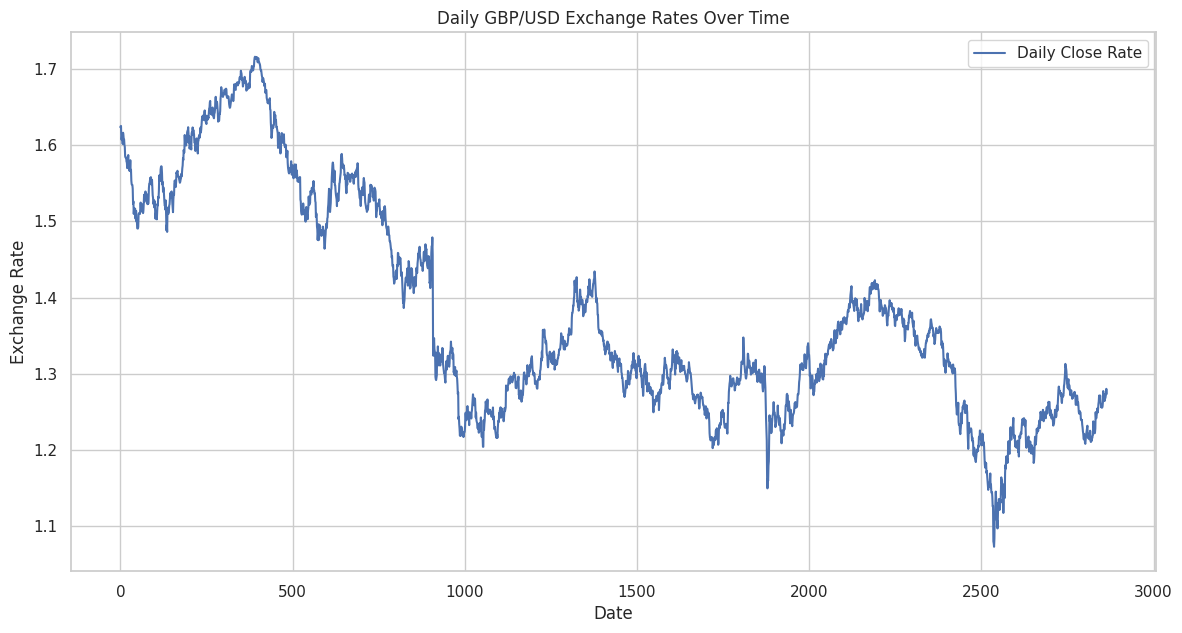

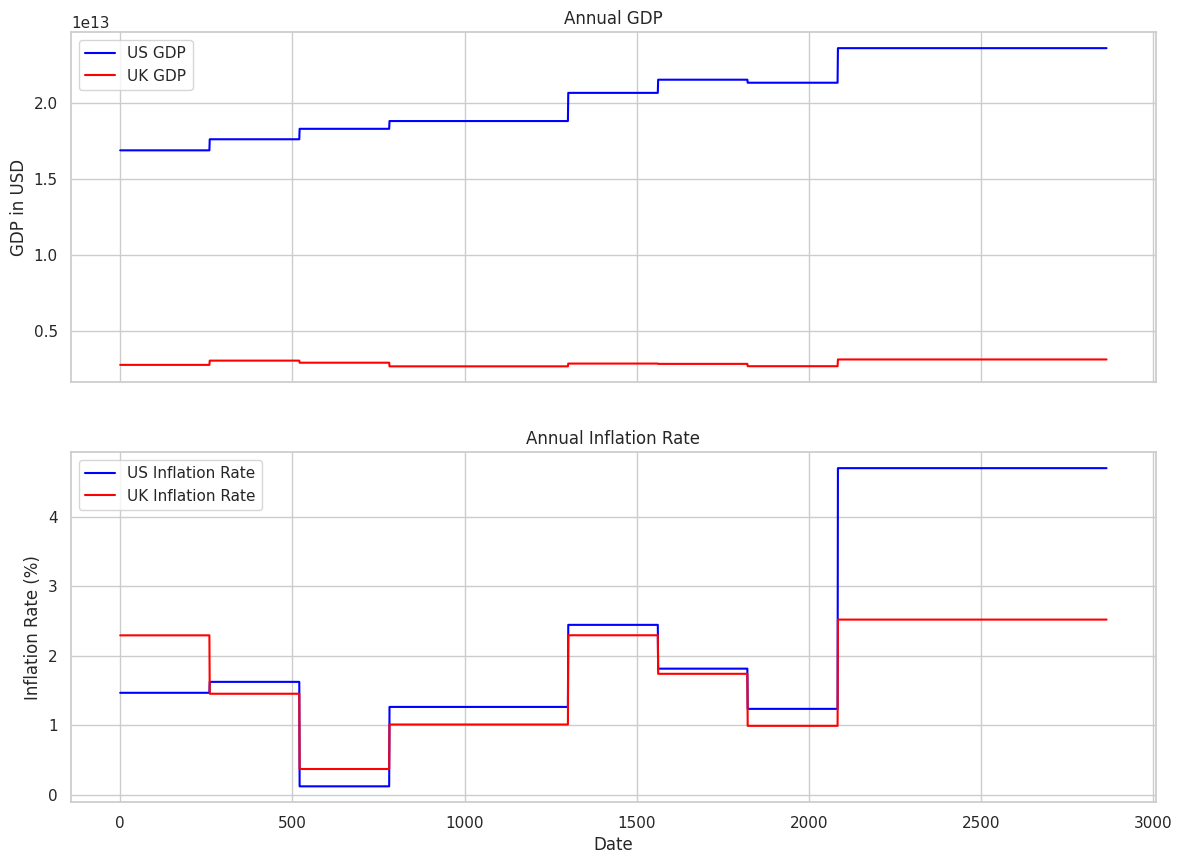

In [28]:
# Visualizing the dataset trends

# Setting the style
sns.set(style="whitegrid")

# Plotting the currency exchange rates
plt.figure(figsize=(14, 7))
plt.plot(cmbd_dt.index, cmbd_dt['Close_GBPUSD=X'], label='Daily Close Rate')
plt.title('Daily GBP/USD Exchange Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Plotting the GDP and Inflation trends
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax[0].plot(cmbd_dt.index, cmbd_dt['GDP_United States'], label='US GDP', color='blue')
ax[0].plot(cmbd_dt.index, cmbd_dt['GDP_United Kingdom'], label='UK GDP', color='red')
ax[0].set_title('Annual GDP')
ax[0].set_ylabel('GDP in USD')
ax[0].legend()

ax[1].plot(cmbd_dt.index, cmbd_dt['Inflation_United States'], label='US Inflation Rate', color='blue')
ax[1].plot(cmbd_dt.index, cmbd_dt['Inflation_United Kingdom'], label='UK Inflation Rate', color='red')
ax[1].set_title('Annual Inflation Rate')
ax[1].set_ylabel('Inflation Rate (%)')
ax[1].set_xlabel('Date')
ax[1].legend()

plt.show()
